# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap


In [2]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [3]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
# EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [4]:
# 이 곳에 답안을 작성해주시길 바랍니다
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    60000 non-null  int64  
 1   DBA Name         60000 non-null  object 
 2   AKA Name         59283 non-null  object 
 3   License #        59996 non-null  float64
 4   Facility Type    58573 non-null  object 
 5   Risk             59976 non-null  object 
 6   Address          60000 non-null  object 
 7   City             59955 non-null  object 
 8   State            59985 non-null  object 
 9   Zip              59987 non-null  float64
 10  Inspection Date  60000 non-null  object 
 11  Inspection Type  60000 non-null  object 
 12  Violations       44130 non-null  object 
 13  Latitude         59822 non-null  float64
 14  Longitude        59822 non-null  float64
 15  Location         59822 non-null  object 
 16  Inspection Fail  60000 non-null  int64  
dtypes: float64(4

In [6]:
train.duplicated().sum() # 중복값 체크

0

In [7]:
train.isna().sum() # 결측값 파악, Violations의 결측값은 해당 사항이 없기 때문에 높은것으로 추정 

Inspection ID          0
DBA Name               0
AKA Name             717
License #              4
Facility Type       1427
Risk                  24
Address                0
City                  45
State                 15
Zip                   13
Inspection Date        0
Inspection Type        0
Violations         15870
Latitude             178
Longitude            178
Location             178
Inspection Fail        0
dtype: int64

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [9]:
# 프로파일링을 통해 대략적인 분석을 진행

#from pandas_profiling import ProfileReport
#profile = ProfileReport(train, minimal=True).to_notebook_iframe()

In [10]:
data_risk1=train[train.Risk=='Risk 1 (High)']
data_risk1.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0
6,580813,WESTINGHOUSE CAMPUS,WESTINGHOUSE HIGH SCHOOL,20068.0,School,Risk 1 (High),3223 W FRANKLIN BLVD,CHICAGO,IL,60624.0,2011-05-09,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.889950,-87.707344,"(-87.70734352860417, 41.88994963311341)",0


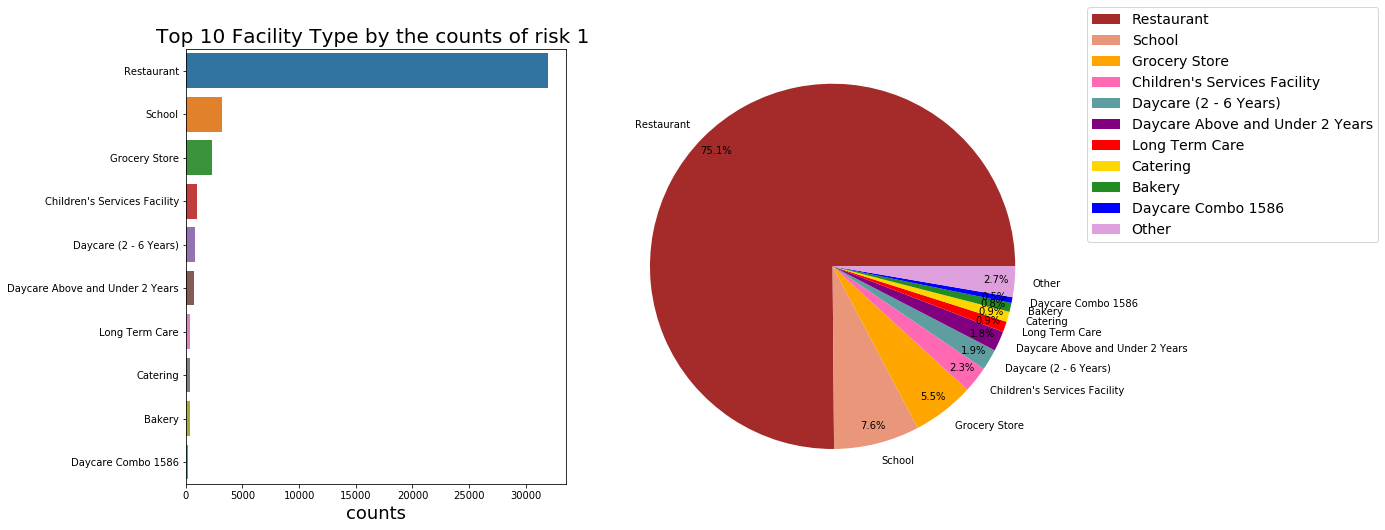

In [11]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk1['Facility Type'].value_counts()[:10],y=data_risk1['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 1 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk1.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk1.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2));

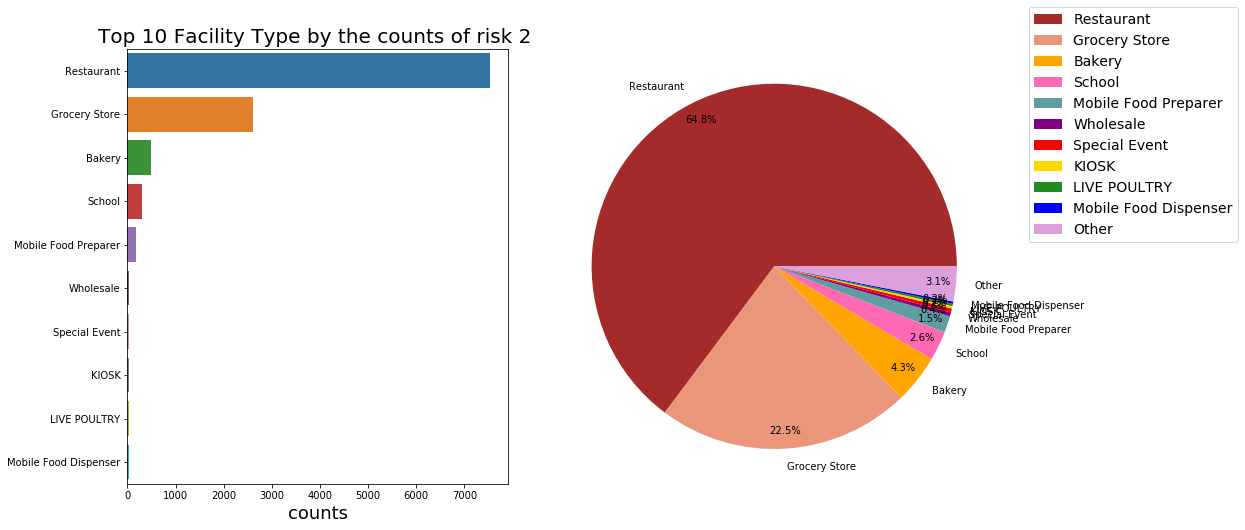

In [12]:
data_risk2=train[train.Risk=='Risk 2 (Medium)']
#data_risk2.head()

fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk2['Facility Type'].value_counts()[:10],y=data_risk2['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 2 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk2.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk2.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

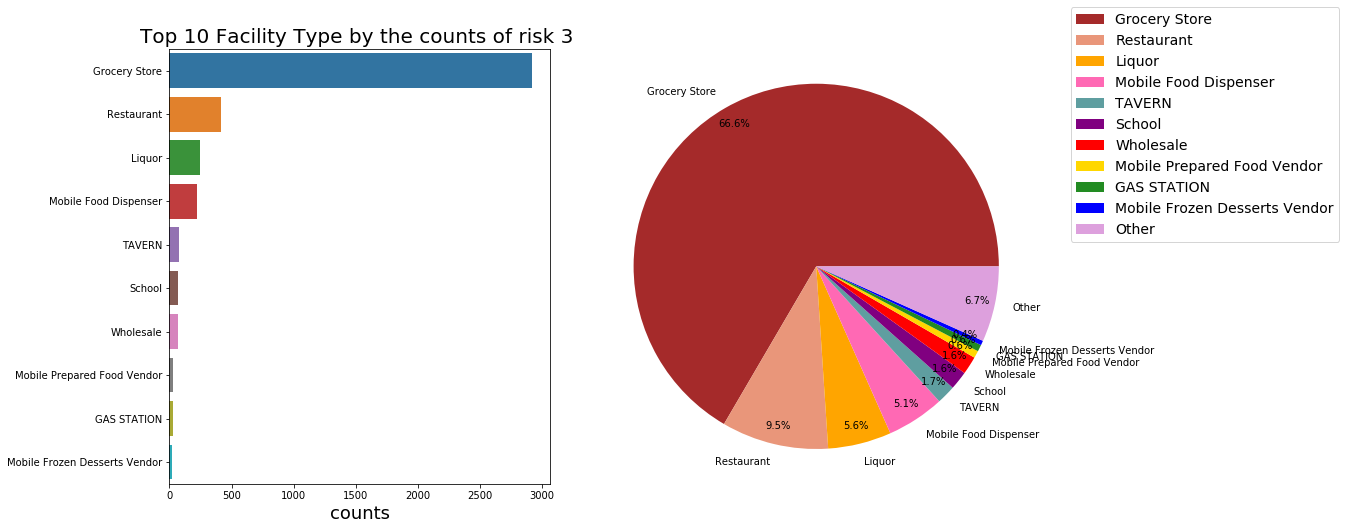

In [13]:
data_risk3=train[train.Risk=='Risk 3 (Low)']
#data_risk3.head()

fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk3['Facility Type'].value_counts()[:10],y=data_risk3['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 3 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk3.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk3.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [14]:
# 이 곳에 답안을 작성해주시길 바랍니다

# 판단상 관측값 식별이 가능하여 데이터 누수가 발생할 수 있는 변수 삭제
# 중복되는 의미의 변수 삭제
# Violations 결측값 대체

# '''
# def engineer(df):
#   df.drop(['Inspection ID',' AKA Name', 'License #', 'Address', 'City', 'State', 'Zip', 'Inspection Date', 'Location'], axis=1, inplace=True)
#   df['Violations'] = df['Violations'].fillna('No Violation')
#   return df
# '''
# def engineer(df):
#   df.drop(['Inspection ID','License #', 'DBA Name', 'AKA Name', 'City', 'State', 'Inspection Date', 'Location'], axis=1, inplace=True)
#   #df['Violations'] = df['Violations'].fillna('No Violation')

#   df['Risk'] = df['Risk'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
#   return df

# train = engineer(train)
# test = engineer(test)

In [15]:
def eda_process(df):
    
    # 복사
    df_temp = df.copy()
    
    
    # State 컬럼 처리 : 결측치 및 IL이 아닌 row 삭제
    df_temp.dropna(subset=["State"], how="any", axis=0, inplace=True)
    df_temp = df_temp[df_temp["State"]=="IL"]
    
    
    # City 컬럼 처리 : Chicago가 맞는 곳과 아닌 곳으로 구분
    Chicago_list = ["CHICAGO", "312CHICAGO", "CHCICAGO","CHICAGO.", "CHICAGOI", "CHICAGOCHICAGO", "CCHICAGO"]
    df_temp["City"] = df_temp["City"].str.upper()
    df_temp["City_Chicago"] = [1 if i in Chicago_list else 0 for i in df_temp['City']]
    
    
    # Inspection date를 string에서 datetime으로 바꾼 후 연도, 월 추출
    df_temp["Inspection Date"] = train['Inspection Date'].apply(pd.to_datetime)
    df_temp["year"] = df_temp["Inspection Date"].dt.year
    df_temp["month"] = df_temp["Inspection Date"].dt.month
    
    
    # Cardinality 줄이기 1 : Facility type upper case > value_counts TOP10 이외는 etc로 처리
    df_temp["Facility Type"] = df_temp["Facility Type"].str.upper()
    facility_top10 = df_temp["Facility Type"].value_counts().sort_values(ascending=False).head(10).index.to_list()
    df_temp["Facility Type"] = [i if i in facility_top10 else "ETC" for i in df_temp['Facility Type']]
    
    
    # Cardinality 줄이기 2 : Inspection Type upper case > value_counts TOP10 이외는 etc로 처리
    df_temp["Inspection Type"] = df_temp["Inspection Type"].str.upper()
    inspection_top10 = df_temp["Inspection Type"].value_counts().sort_values(ascending=False).head(10).index.to_list()
    df_temp["Inspection Type"] = [i if i in inspection_top10 else "ETC" for i in df_temp["Inspection Type"]]
    
    
    # Cardinality 줄이기 3 : Violations 결측치 0으로 보완 > "|"으로 Split > len()을 사용하여 위반사항 "개수"로 변환
    df_temp["Violations"].fillna(0, inplace=True)
    df_temp["Violations"] = [0 if i == 0 else len(i.split("| ")) for i in df_temp["Violations"]]
    
    
    # Cardinality 줄이기 4 : License # > 결측치는 0, 고유번호가 있으면 1
    df_temp["License #"].fillna(0, inplace=True)
    df_temp["License"] = [0 if i == 0  else 1 for i in df_temp["License #"]]
    
    
    # Cardinality 줄이기  5 :
    df_temp["Name"] = df_temp["DBA Name"].str.upper()
    
    macdonald = set(df_temp["Name"][df_temp["Name"].str.contains("MCDONALD|MC DONALD'S|MC DONALDS")].values)
    df_temp.replace(macdonald, 'MCDONALDS', inplace=True)
    subways = set(df_temp["Name"][df_temp["Name"].str.contains("SUBWAY")].values)
    df_temp.replace(subways, 'SUBWAY', inplace=True)
    potbelly = set(df_temp["Name"][df_temp["Name"].str.contains("POTBELLY")].values)
    df_temp.replace(potbelly, 'POTBELLY SANDWICH WORKS', inplace=True)
    jimmy = set(df_temp["Name"][df_temp["Name"].str.contains("JIMMY JOHN")].values)
    df_temp.replace(jimmy, 'JIMMY JOHNS', inplace=True)
    dunkin_and_baskin = set(df_temp["Name"][df_temp["Name"].str.contains("DUNKIN DONUTS BASKIN ROBBINS|DUNKIN DONUTS/BASKIN ROBBINS|DUNKIN DONUTS / BASKIN ROBBINS")].values)
    df_temp.replace(dunkin_and_baskin, 'DUNKIN DONUTS/BASKIN ROBBINS', inplace=True)
    kfc = set(df_temp["Name"][df_temp["Name"].str.contains("KENTUCKY FRIED CHICKEN|KFC")].values)
    df_temp.replace(kfc, 'KFC', inplace=True)
    wendys = set(df_temp["Name"][df_temp["Name"].str.contains("WENDY")].values)
    df_temp.replace(wendys, "WENDYS", inplace=True)
    popeyes = set(df_temp["Name"][df_temp["Name"].str.contains("POPEYE")].values)
    df_temp.replace(popeyes, "POPEYES", inplace=True)
    domino = set(df_temp["Name"][df_temp["Name"].str.contains("DOMINO")].values)
    df_temp.replace(domino, "DOMINOS PIZZA", inplace=True)
    reggio = set(df_temp["Name"][df_temp["Name"].str.contains("REGGIO")].values)
    df_temp.replace(reggio, "REGGIOS PIZZA", inplace=True)
    seven = set(df_temp["Name"][df_temp["Name"].str.contains("ELEVEN")].values)
    df_temp.replace(seven, "7-ELEVEN", inplace=True)
    starbucks = set(df_temp["Name"][df_temp["Name"].str.contains("STARBUCKS")].values)
    df_temp.replace(starbucks, "STARBUCKS", inplace=True)
    papa = set(df_temp["Name"][df_temp["Name"].str.contains("PAPA JOHN")].values)
    df_temp.replace(papa, "PAPA JOHNS PIZZA", inplace=True)
    tacobell = set(df_temp["Name"][df_temp["Name"].str.contains("TACO BELL")].values)
    df_temp.replace(tacobell, "TACO BELL", inplace=True)
    wingstop = set(df_temp["Name"][df_temp["Name"].str.contains("WINGSTOP")].values)
    df_temp.replace(wingstop, "WINGSTOP", inplace=True)
    see = set(df_temp["Name"][df_temp["Name"].str.contains("SEE THRU CHINESE KITCHEN")].values)
    df_temp.replace(see, "SEE THRU CHINESE KITCHEN", inplace=True)
    harold = set(df_temp["Name"][df_temp["Name"].str.contains("HAROLD'S CHICKEN SHACK")].values)
    df_temp.replace(harold, "HAROLD'S CHICKEN SHACK", inplace=True)
    pizzahut = set(df_temp["Name"][df_temp["Name"].str.contains("PIZZA HUT")].values)
    df_temp.replace(pizzahut, "PIZZA HUT", inplace=True)
    chart = set(df_temp["Name"][df_temp["Name"].str.contains("CHARTWELLS")].values)
    df_temp.replace(chart, "CHARTWELLS", inplace=True)
    
    
    # Risk : 결측치 및 All 삭제 > 1, 2, 3으로 바꾸어 줌
    df_temp.dropna(subset=["Risk"], how="any", axis=0, inplace=True)
    df_temp.drop(df_temp.loc[df_temp['Risk']=='All'].index, inplace=True)
    df_temp.replace('Risk 1 (High)', 1, inplace=True)
    df_temp.replace('Risk 2 (Medium)', 2, inplace=True)
    df_temp.replace('Risk 3 (Low)', 3, inplace=True)
    
    
    # 필요한 features 선택
    features = ["Name", "year", "month", "License", "Facility Type", "City_Chicago", "Latitude", "Longitude",  
                "Risk", "Inspection Type", "Violations", "Inspection Fail"]
    feature = df_temp[features]
       
    
    return feature

In [16]:
train_eda = eda_process(train)
test_eda = eda_process(test)

test_eda = eda_process(test)

In [17]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59947 entries, 0 to 59999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             59947 non-null  object 
 1   year             59947 non-null  int64  
 2   month            59947 non-null  int64  
 3   License          59947 non-null  int64  
 4   Facility Type    59947 non-null  object 
 5   City_Chicago     59947 non-null  int64  
 6   Latitude         59772 non-null  float64
 7   Longitude        59772 non-null  float64
 8   Risk             59947 non-null  int64  
 9   Inspection Type  59947 non-null  object 
 10  Violations       59947 non-null  int64  
 11  Inspection Fail  59947 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 5.9+ MB


# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [18]:
# 이 곳에 답안을 작성해주시길 바랍니다

# CV

target = 'Inspection Fail'

# features & target 분리
y_train = train_eda[target]
X_train = train_eda.drop(target, axis=1)

y_test = test_eda[target]
X_test = test_eda.drop(target, axis=1)

In [19]:
X_train.head(2)

,Name,year,month,License,Facility Type,City_Chicago,Latitude,Longitude,Risk,Inspection Type,Violations
0,MY SWEET STATION INC,2017,5,1,RESTAURANT,1,41.927577,-87.651528,1,CANVASS,0
1,OUTTAKES,2017,8,1,RESTAURANT,1,41.881807,-87.629543,2,CANVASS,3


In [20]:
X_test.head(2)

,Name,year,month,License,Facility Type,City_Chicago,Latitude,Longitude,Risk,Inspection Type,Violations
0,DUNKIN' DONUTS/JET BOX,2017,5,1,RESTAURANT,1,41.789329,-87.741646,2,CANVASS,0
1,WHALE FISH AND CHICKEN INC,2017,8,1,RESTAURANT,1,41.880330,-87.749790,2,SHORT FORM COMPLAINT,4


In [21]:
y_test

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: Inspection Fail, Length: 19994, dtype: int64

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [22]:
# 이 곳에 답안을 작성해주시길 바랍니다

from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
ratio = 0.243523/0.756477

pre_process = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median')
)

X_train_processed = pre_process.fit_transform(X_train)
X_test_processed = pre_process.transform(X_test)

X_train_processed = pd.DataFrame(data=X_train_processed, columns=X_train.columns)
X_test_processed = pd.DataFrame(data = X_test_processed, columns=X_test.columns)

In [26]:
xgb_cf = XGBClassifier(n_estimators=1000
                  , learning_rate = 0.4
                  , colsample_bytree = 0.6
                  , missing=-999
                  #, tree_method='gpu_hist'
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=7
                 )

xgb_cf.fit(X_train_processed, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

y_test_pred = xgb_cf.predict(X_test_processed)
y_test_pred_proba = xgb_cf.predict_proba(X_test_processed)[:, -1]


# AUC Score
print('AUC score: ', roc_auc_score(y_test, y_test_pred_proba))

AUC score:  0.7715876447956692


In [28]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     16096
           1       0.50      0.37      0.42      3898

    accuracy                           0.81     19994
   macro avg       0.68      0.64      0.65     19994
weighted avg       0.79      0.81      0.79     19994



In [29]:
print('xgb_cf의 f1_score:', f1_score(y_test, y_test_pred))

xgb_cf의 f1_score: 0.4224892449191514


## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [32]:
# 이 곳에 답안을 작성해주시길 바랍니다

from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV



params = { 
    'simpleimputer__strategy': ['median'],
    'xgbclassifier__max_depth' : [5],
    'xgbclassifier__min_child_weight':[5],
    'xgbclassifier__colsample_bytree':[0.9]

}

gridcv = GridSearchCV(
    xgb_cf, 
    param_grid=params, 
    cv=3,
    verbose=1,
    n_jobs=-1,
    refit=True)

gridcv.fit(X_train_processed, y_train)


"""
GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('...
                                                      seed=None, silent=None,
                                                      subsample=1,
                                                      verbosity=1))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'simpleimputer__strategy': ['median'],
                         'xgbclassifier__colsample_bytree': [0.5, 0.75, 0.9],
                         'xgbclassifier__max_depth': [5, 7, 9],
                         'xgbclassifier__min_child_weight': [1, 3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5}
accuracy:  0.8012499999999999
검증 정확도 0.8039166666666666
F1 score: 0.00507399577167019   

"""

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


"\nGridSearchCV(cv=3, error_score=nan,\n             estimator=Pipeline(memory=None,\n                                steps=[('ordinalencoder',\n                                        OrdinalEncoder(cols=None,\n                                                       drop_invariant=False,\n                                                       handle_missing='value',\n                                                       handle_unknown='value',\n                                                       mapping=None,\n                                                       return_df=True,\n                                                       verbose=0)),\n                                       ('simpleimputer',\n                                        SimpleImputer(add_indicator=False,\n                                                      copy=True,\n                                                      fill_value=None,\n                                                      missing_value

In [33]:
print('최적 하이퍼파라미터: ', gridcv.best_params_)
print('accuracy: ', gridcv.best_score_)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5}
accuracy:  0.8257627681357199


In [34]:
# f1 score 이전값: 
print('xgb_cf의 f1_score:', f1_score(y_test, y_test_pred))

xgb_cf의 f1_score: 0.4224892449191514


In [36]:
# f1 score 튜닝후 값: 
print('random_clf의 f1_score:', gridcv.score(X_test_processed, y_test))

random_clf의 f1_score: 0.8052915874762429


## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [37]:
import eli5
from eli5.sklearn import PermutationImportance
import shap

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [38]:
permuter = PermutationImportance(
    gridcv, 
    scoring='f1', 
    n_iter=5,
    random_state=10
)


permuter.fit(X_test_processed, y_test);


feature_names = X_test.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.2021 ± 0.0086,Violations
0.0565 ± 0.0133,Inspection Type
0.0169 ± 0.0054,Longitude
0.0137 ± 0.0042,Latitude
0.0041 ± 0.0035,Name
0.0018 ± 0.0025,Facility Type
0.0001 ± 0.0006,License
0.0001 ± 0.0001,City_Chicago
-0.0017 ± 0.0035,Risk
-0.0027 ± 0.0066,month


In [42]:
model = gridcv.best_estimator_
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, simpleimputer__strategy='median', subsample=1,
              verbosity=1, xgbclassifier__colsample_bytree=0.9,
              xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5)

In [43]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(model)

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100], X_test.iloc[:100], plot_cmap=["#FF5733","#335BFF"])

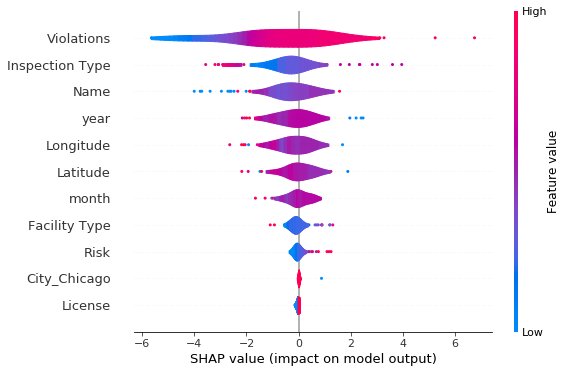

In [45]:
shap.initjs()

X_test_df = pd.DataFrame(X_test_processed, columns=X_test.columns)

shap_values = explainer.shap_values(X_test_df.iloc[:100])
shap.summary_plot(shap_values, X_test_df.iloc[:100], plot_type="violin")